## Forecast Model Comparison


**2023 Hold‑out RMSE (sorted)**

| Model         | RMSE    |
|:--------------|:--------|
| XGB (Hedonic) | 1258.31 |
| XGB (TS Lags) | 3830.81 |
| Random Forest | 4990.01 |
| SVR           | 5951.19 |
| ARIMA         | 10988.5 |


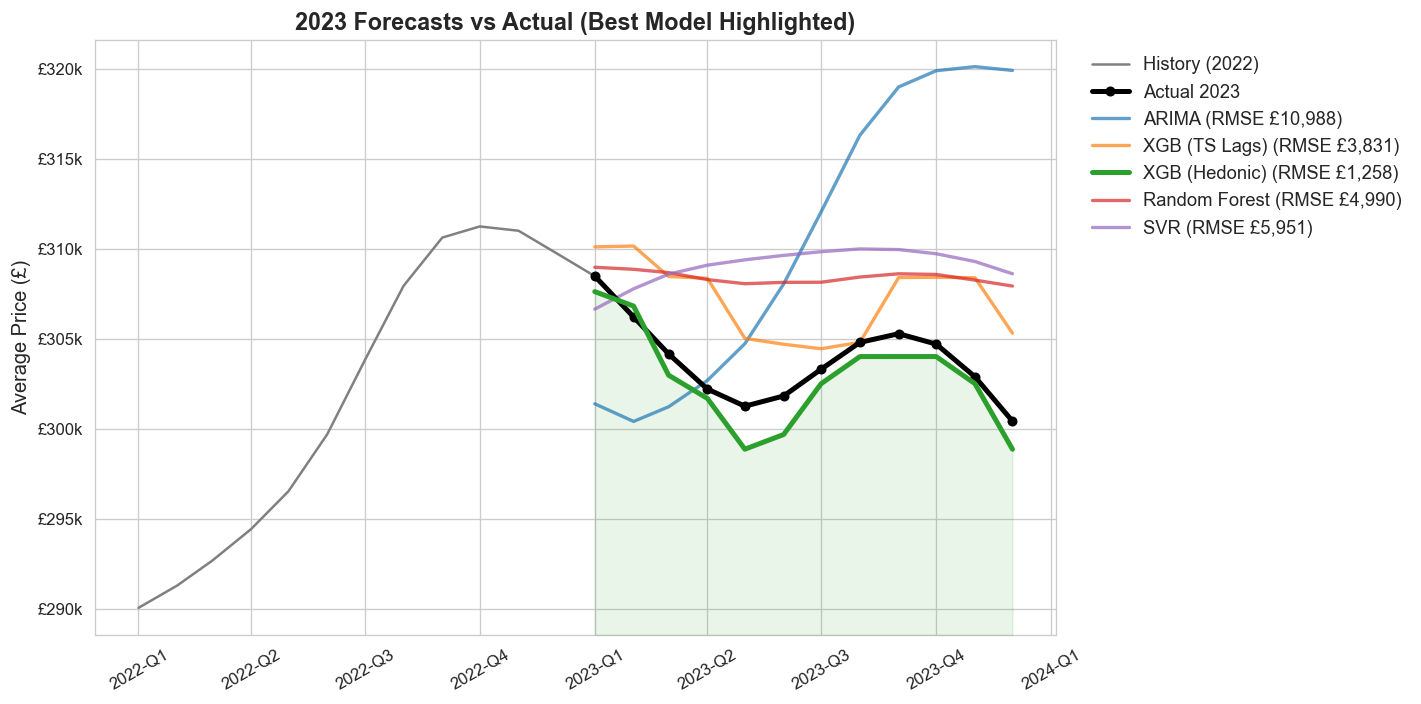

In [108]:
# === Overlay All 2023 Forecasts with Metrics Table ===

ser   = df_processed.groupby("Date")["AveragePrice"].mean().asfreq("MS").ffill()
train, test = ser[:-12], ser[-12:]

# Defining train_data as the full historical series
train_data = ser
# Defining test_data as the actual 2023 series
test_data  = test

preds = {
    "ARIMA":         (arima_pred,    rmse_arima),
    "XGB (TS Lags)": (xgb_ts_pred,   rmse_xg_t),
    "XGB (Hedonic)": (h_pred,        rmse_xg_h),
    "Random Forest": (rf_pred,       rmse_rf),
    "SVR":           (svr_pred,      rmse_svr),
}

# --- Build & print a small metrics table ---
metrics_df = (
    pd.DataFrame([{"Model": m, "RMSE": r} for m,(_,r) in preds.items()])
      .sort_values("RMSE")
)
print("**2023 Hold‑out RMSE (sorted)**\n")
# Use numalign="left" for consistent markdown table formatting
print(metrics_df.to_markdown(index=False, numalign="left"))

# --- Plot historical, actual and all forecasts ---
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12,6), dpi=120)

# a) historical 2022 (subset of the full history)
hist2022 = train_data[train_data.index >= "2022-01-01"]
ax.plot(hist2022.index, hist2022.values,
        color="gray", lw=1.5, label="History (2022)")

# b) actual 2023
ax.plot(test_data.index, test_data.values,
        color="black", lw=3, marker="o", markersize=5,
        label="Actual 2023", zorder=5)

# c) forecasts
palette   = sns.color_palette("tab10", n_colors=len(preds))
best_model = metrics_df.iloc[0]["Model"]

for i, (model_name, (fc, rmse)) in enumerate(preds.items()):
    is_best = (model_name == best_model)
    model_color = palette[i % len(palette)]

    ax.plot(fc.index, fc.values,
            label = f"{model_name} (RMSE £{rmse:,.0f})",
            color = model_color, # Use the assigned color
            lw    = 3 if is_best else 2,
            alpha = 1.0 if is_best else 0.7,
            zorder= 6 if is_best else 4)

# d) shade under best‑model curve
best_series = preds[best_model][0]
ymin, ymax = ax.get_ylim()
best_model_index = list(preds.keys()).index(best_model)
best_model_color = palette[best_model_index]

ax.fill_between(best_series.index, ymin, best_series.values,
                color=best_model_color, 
                alpha=0.1, zorder=3)
ax.set_ylim(ymin, ymax)

# --- Formatting ---
# quarterly x‑ticks
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1,4,7,10]))
ax.xaxis.set_major_formatter(
    mticker.FuncFormatter(
        lambda x,pos: f"{mdates.num2date(x).year}-Q{((mdates.num2date(x).month-1)//3+1)}"
    )
)
plt.setp(ax.get_xticklabels(), rotation=30)

# y‑axis in £k
ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(lambda y,pos: f"£{y/1e3:,.0f}k")
)

ax.set_title("2023 Forecasts vs Actual (Best Model Highlighted)", fontsize=14, fontweight="bold")
ax.set_xlabel("")
ax.set_ylabel("Average Price (£)") # Add currency symbol to y-label

# legend placed outside
ax.legend(loc="upper left", bbox_to_anchor=(1.02,1), frameon=False)

plt.tight_layout()
plt.show()
